### Import Dependences

In [418]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import transformers
from transformers import AutoTokenizer
from transformers import  DistilBertForTokenClassification ## Main

from torch.optim import AdamW

import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score

### Data prepocessing


#### Load Data

In [419]:
df= pd.read_csv('ner_dataset.csv',encoding='latin1',  error_bad_lines=False)
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [420]:
#Fill NAN
df =df.fillna(method ="ffill")
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [421]:
#Data describe
df.describe()

,Sentence #,Word,POS,Tag
count,1048575,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 22480,the,NN,O
freq,104,52573,145807,887908


In [423]:
tag_df= pd.DataFrame()
tag_df["count"]= df["Tag"].value_counts()

<AxesSubplot:>

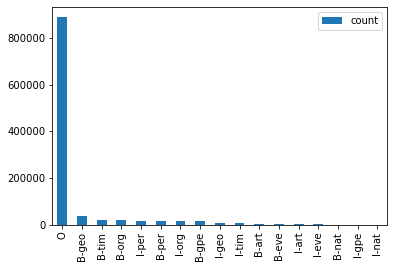

In [424]:
tag_df.plot.bar()

In [364]:
#Encode sentence#
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [365]:
df["Sentence #"] = LabelEncoder().fit_transform(df["Sentence #"])
df.head()

,Sentence #,Word,POS,Tag
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O


In [366]:
#Null Value Check
df.isna().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [374]:
#change columns names
df.rename(columns = {"Sentence #": "sentence_id", "Word":"sentence", "Tag": "tags"}, inplace = True)

In [375]:
df["tags"] = df["tags"].str.upper()
df.head()

,sentence_id,sentence,POS,tags
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O


In [376]:
#Group the text and labels
df_sentence = df.groupby('sentence_id')['sentence'].apply(list)
df_tags = df.groupby('sentence_id')['tags'].apply(list)


In [377]:
sent_list = []
for s in df_sentence:
    sent = ' '.join(s)
    sent_list.append(sent)
    

sent_list[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [378]:
tags_list = []
for t in df_tags:
    tg = ' '.join(t)
    tags_list.append(tg)
    

tags_list[1]

'B-GPE O O O O O O O O O O O O O O B-TIM O O O B-ORG O O O O O'

In [379]:
#Unique sentence_id
unique_sentenceId = df.sentence_id.unique()
df_unique_sent_id = pd.DataFrame()
df_unique_sent_id["sentence_id"] = unique_sentenceId
df_unique_sent_id.head()

,sentence_id
0,0
1,11111
2,22222
3,33333
4,42404


In [380]:
df_unique_sent_id['sentence'] = sent_list
df_unique_sent_id['tags']= tags_list
df_unique_sent_id.head()

,sentence_id,sentence,tags
0,0,Thousands of demonstrators have marched throug...,O O O O O O B-GEO O O O O O B-GEO O O O O O B-...
1,11111,Iranian officials say they expect to get acces...,B-GPE O O O O O O O O O O O O O O B-TIM O O O ...
2,22222,Helicopter gunships Saturday pounded militant ...,O O B-TIM O O O O O B-GEO O O O O O B-ORG O O ...
3,33333,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,42404,U.N. relief coordinator Jan Egeland said Sunda...,B-GEO O O B-PER I-PER O B-TIM O B-GEO O B-GPE ...


In [381]:
df= df_unique_sent_id.drop(['sentence_id'], axis=1)
df.tail()

,sentence,tags
47954,Opposition leader Mir Hossein Mousavi has said...,O O O B-PER I-PER O O O O O O O O O O O O O O ...
47955,"On Thursday , Iranian state media published a ...",O B-TIM O B-GPE O O O O O O O O B-ORG I-ORG O ...
47956,"Following Iran 's disputed June 12 elections ,...",O B-GEO O O B-TIM I-TIM O O O O O O O O O O O ...
47957,"Since then , authorities have held public tria...",O O O O O O O O O O O O O O O O O O O O O
47958,The United Nations is praising the use of mili...,O B-ORG I-ORG O O O O O O O O O O O O O O B-TI...


In [382]:
df.isnull().sum()

sentence    0
tags        0
dtype: int64

### Split Dataset

In [383]:
X = df["sentence"]
y = df["tags"]

In [384]:
#!pip install imblearn

In [385]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [386]:
df_train = pd.DataFrame()
df_train["sentence"] = X_train
df_train["tags"] = y_train

df_dev = pd.DataFrame()
df_dev["sentence"] = X_test
df_dev["tags"] = y_test


In [387]:
print("Train count: ",len(df_train))
print("Test count: ",len(df_dev))

Train count:  38367
Test count:  9592


### Distilbert Class

In [388]:
class DistilbertNER(nn.Module):
  """
  Implement NN class based on distilbert pretrained from Hugging face.
  Inputs : 
    tokens_dim : int specifyng the dimension of the classifier
  """
  
  def __init__(self, tokens_dim):
    super(DistilbertNER,self).__init__()
    
    if type(tokens_dim) != int:
            raise TypeError('Please tokens_dim should be an integer')

    if tokens_dim <= 0:
          raise ValueError('Classification layer dimension should be at least 1')

    self.pretrained = DistilBertForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels = tokens_dim) #set the output of each token classifier = unique_lables


  def forward(self, input_ids, attention_mask, labels = None): #labels are needed in order to compute the loss
    """
  Forwad computation of the network
  Input:
    - inputs_ids : from model tokenizer
    - attention :  mask from model tokenizer
    - labels : if given the model is able to return the loss value
  """

    #inference time no labels
    if labels == None:
      out = self.pretrained(input_ids = input_ids, attention_mask = attention_mask )
      return out

    out = self.pretrained(input_ids = input_ids, attention_mask = attention_mask , labels = labels)
    return out

### Dataset Class

In [389]:
class NerDataset(torch.utils.data.Dataset):
  """
  Custom dataset implementation to get (text,labels) tuples
  Inputs:
   - df : dataframe with columns [tags, sentence]
  """
  
  def __init__(self, df):
    if not isinstance(df, pd.DataFrame):
      raise TypeError('Input should be a dataframe')
    
    if "tags" not in df.columns or "sentence" not in df.columns:
      raise ValueError("Dataframe should contain 'tags' and 'sentence' columns")

     
    
    tags_list = [i.split() for i in df["tags"].values.tolist()]
    texts = df["sentence"].values.tolist()

    self.texts = [tokenizer(text, padding = "max_length", truncation = True, return_tensors = "pt") for text in texts]
    self.labels = [match_tokens_labels(text, tags) for text,tags in zip(self.texts, tags_list)]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    batch_text = self.texts[idx]
    batch_labels = self.labels[idx]

    return batch_text, torch.LongTensor(batch_labels)

### Evaluation Matrix

In [390]:
class MetricsTracking():
  """
  In order make the train loop lighter I define this class to track all the metrics that we are going to measure for our model.
  """
  def __init__(self):

    self.total_acc = 0
    self.total_f1 = 0
    self.total_precision = 0
    self.total_recall = 0

  def update(self, predictions, labels , ignore_token = -100):
    '''
    Call this function every time you need to update your metrics.
    Where in the train there was a -100, were additional token that we dont want to label, so remove them.
    If we flatten the batch its easier to access the indexed = -100
    '''  
    predictions = predictions.flatten()
    labels = labels.flatten()
    
    predictions = predictions[labels != ignore_token]
    labels = labels[labels != ignore_token]

    predictions = predictions.to("cpu")
    labels = labels.to("cpu")

    acc = accuracy_score(labels,predictions)
    f1 = f1_score(labels, predictions, average = "macro")
    precision = precision_score(labels, predictions, average = "macro")
    recall = recall_score(labels, predictions, average = "macro")

    self.total_acc  += acc
    self.total_f1 += f1
    self.total_precision += precision
    self.total_recall  += recall

  def return_avg_metrics(self,data_loader_size):
    n = data_loader_size
    metrics = {
        "acc": round(self.total_acc / n ,3), 
        "f1": round(self.total_f1 / n, 3), 
        "precision" : round(self.total_precision / n, 3), 
        "recall": round(self.total_recall / n, 3)
          }
    return metrics  

### Tags Mapping

In [391]:
def tags_2_labels(tags : str, tag2idx : dict):
  '''
  Method that takes a list of tags and a dictionary mapping and returns a list of labels (associated).
  Used to create the "label" column in df from the "tags" column.
  '''
  return [tag2idx[tag] if tag in tag2idx else unseen_label for tag in tags.split()]


def tags_mapping(tags_series : pd.Series):
  """
  tag_series = df column with tags for each sentence.
  Returns:
    - dictionary mapping tags to indexes (label)
    - dictionary mappign inedexes to tags
    - The label corresponding to tag 'O'
    - A set of unique tags ecountered in the trainind df, this will define the classifier dimension
  """

  if not isinstance(tags_series, pd.Series):
      raise TypeError('Input should be a padas Series')

  unique_tags = set()
  
  for tag_list in df_train["tags"]:
    for tag in tag_list.split():
      unique_tags.add(tag)


  tag2idx = {k:v for v,k in enumerate(sorted(unique_tags))}
  idx2tag = {k:v for v,k in tag2idx.items()}

  unseen_label = tag2idx["O"]

  return tag2idx, idx2tag, unseen_label, unique_tags

### Token Matching

In [392]:
def match_tokens_labels(tokenized_input, tags, ignore_token = -100):
        '''
        Used in the custom dataset.
        -100 will be the label used to match additional tokens like [CLS] [PAD] that we dont care about. 
        Inputs : 
          - tokenized_input : tokenizer over the imput text -> {input_ids, attention_mask}
          - tags : is a single label array -> [O O O O O O O O O O O O O O B-tim O]
        
        Returns a list of labels that match the tokenized text -> [-100, 3,5,6,-100,...]
        '''

        #gives an array [ None , 0 , 1 ,2 ,... None]. Each index tells the word of reference of the token
        word_ids = tokenized_input.word_ids()

        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:

            if word_idx is None:
                label_ids.append(ignore_token)

            #if its equal to the previous word we can add the same label id of the provious or -100 
            else :
                try:
                    reference_tag = tags[word_idx]
                    label_ids.append(tag2idx[reference_tag])
                except:
                    label_ids.append(ignore_token)
              
            
            previous_word_idx = word_idx

        return label_ids

### Train Looping

In [393]:
def train_loop(model, train_dataset, dev_dataset, optimizer,  batch_size, epochs):
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    dev_dataloader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    #variables to hold each evaluation
    loss_t = []
    acc_t= []
    f1_t = []
    p_t = []
    r_t = []
    
    loss_v = []
    acc_v= []
    f1_v = []
    p_v = []
    r_v = []

    for epoch in range(epochs) : 
    
        train_metrics = MetricsTracking()
        total_loss_train = 0

        model.train() #train mode

        for train_data, train_label in tqdm(train_dataloader):
            
            train_label = train_label.to(device)
            '''
              squeeze in order to match the sizes. From [batch,1,seq_len] --> [batch,seq_len] 
            '''
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()

            output = model(input_id, mask, train_label)
            loss, logits = output.loss, output.logits
            predictions = logits.argmax(dim= -1) 

          #compute metrics
            train_metrics.update(predictions, train_label)
            total_loss_train += loss.item()

          #grad step
            loss.backward()
            optimizer.step()

        '''
        EVALUATION MODE
        '''            
        model.eval()

        dev_metrics = MetricsTracking()
        total_loss_dev = 0

        with torch.no_grad():
            for dev_data, dev_label in dev_dataloader:

                dev_label = dev_label.to(device)

                mask = dev_data['attention_mask'].squeeze(1).to(device)
                input_id = dev_data['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask, dev_label)
                loss, logits = output.loss, output.logits

                predictions = logits.argmax(dim= -1)     

                dev_metrics.update(predictions, dev_label)
                total_loss_dev += loss.item()

        train_results = train_metrics.return_avg_metrics(len(train_dataloader))
        dev_results = dev_metrics.return_avg_metrics(len(dev_dataloader))

        loss_rate_train = total_loss_train / len(train_dataset)
        loss_rate_dev = total_loss_dev / len(dev_dataset)

        loss_t.append(loss_rate_train)
        acc_t.append(train_results["acc"])
        f1_t.append(train_results["f1"])
        p_t.append(train_results["precision"])
        r_t.append(train_results["recall"])

        loss_v.append(loss_rate_dev)
        acc_v.append(train_results["acc"])
        f1_v.append(dev_results["f1"])
        p_v.append(dev_results["precision"])
        r_v.append(dev_results["recall"])

        print(f"TRAIN \nLoss: {loss_rate_train} \nMetrics {train_results}\n" ) 
        print(f"TEST \nLoss {loss_rate_dev} \nMetrics{dev_results}\n" ) 

    
    all_list = [[loss_t, acc_t, f1_t, p_t, r_t], [loss_v, acc_v, f1_v, p_v, r_v]]
    
    return all_list

### Main Scope

In [394]:
#create tag-label mapping
tag2idx, idx2tag , unseen_label, unique_tags = tags_mapping(df_train["tags"])

#create the label column from tag. Unseen labels will be tagged as "O"
for df in [df_train, df_dev, df_test]:
    df["labels"] = df["tags"].apply(lambda tags : tags_2_labels(tags, tag2idx))

In [395]:
#original text
text = df_train["sentence"].values.tolist()

#toeknized text
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_tokenized = tokenizer(text , padding = "max_length" , truncation = True, return_tensors = "pt" )

#mapping token to original word
word_ids = text_tokenized.word_ids()

In [ ]:
%%time
model = DistilbertNER(len(unique_tags))


#datasets
train_dataset = NerDataset(df_train)
dev_dataset = NerDataset(df_dev)

lr = 1e-2
optimizer = SGD(model.parameters(), lr=lr, momentum = 0.9)  


#MAIN
parameters = {
    "model": model,
    "train_dataset": train_dataset,
    "dev_dataset" : dev_dataset,
    "optimizer" : optimizer,
    "batch_size" : 32,
    "epochs" : 10
}

start_train = train_loop(**parameters)

#Capture evaluation into list
epoch_list = []
for i in range(1,parameters["epochs"]+1):
    epoch_list.append(i)

train_loss_list = start_train[0][0]
train_acc_list = start_train[0][1]
train_f1_list = start_train[0][2]
train_prec_list = start_train[0][3]
train_recall_list = start_train[0][4]

test_loss_list = start_train[1][0]
test_acc_list = start_train[1][1]
test_f1_list = start_train[1][2]
test_prec_list = start_train[1][3]
test_recall_list = start_train[1][4]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

TRAIN 
Loss: 0.009821601109296899 
Metrics {'acc': 0.908, 'f1': 0.548, 'precision': 0.64, 'recall': 0.515}

TEST 
Loss 0.006400722524833192 
Metrics{'acc': 0.934, 'f1': 0.672, 'precision': 0.713, 'recall': 0.665}



100%|██████████| 1199/1199 [15:58<00:00,  1.25it/s]


TRAIN 
Loss: 0.005868943290111156 
Metrics {'acc': 0.939, 'f1': 0.69, 'precision': 0.744, 'recall': 0.672}

TEST 
Loss 0.005298049109533516 
Metrics{'acc': 0.945, 'f1': 0.713, 'precision': 0.739, 'recall': 0.716}



100%|██████████| 1199/1199 [15:57<00:00,  1.25it/s]


TRAIN 
Loss: 0.004774803634451674 
Metrics {'acc': 0.95, 'f1': 0.735, 'precision': 0.775, 'recall': 0.726}

TEST 
Loss 0.00498383196484021 
Metrics{'acc': 0.949, 'f1': 0.728, 'precision': 0.761, 'recall': 0.725}



100%|██████████| 1199/1199 [15:58<00:00,  1.25it/s]


TRAIN 
Loss: 0.00411784053229433 
Metrics {'acc': 0.957, 'f1': 0.761, 'precision': 0.795, 'recall': 0.753}

TEST 
Loss 0.004651550769035373 
Metrics{'acc': 0.953, 'f1': 0.748, 'precision': 0.765, 'recall': 0.757}



100%|██████████| 1199/1199 [15:57<00:00,  1.25it/s]


TRAIN 
Loss: 0.003574004512097976 
Metrics {'acc': 0.962, 'f1': 0.788, 'precision': 0.816, 'recall': 0.782}

TEST 
Loss 0.004696823047587432 
Metrics{'acc': 0.955, 'f1': 0.747, 'precision': 0.779, 'recall': 0.744}



100%|██████████| 1199/1199 [15:57<00:00,  1.25it/s]


TRAIN 
Loss: 0.0031215608802356767 
Metrics {'acc': 0.966, 'f1': 0.808, 'precision': 0.831, 'recall': 0.804}

TEST 
Loss 0.004752198236142351 
Metrics{'acc': 0.955, 'f1': 0.749, 'precision': 0.773, 'recall': 0.749}



100%|██████████| 1199/1199 [15:58<00:00,  1.25it/s]


TRAIN 
Loss: 0.002792988071681719 
Metrics {'acc': 0.969, 'f1': 0.825, 'precision': 0.847, 'recall': 0.822}

TEST 
Loss 0.004823215256481617 
Metrics{'acc': 0.956, 'f1': 0.75, 'precision': 0.771, 'recall': 0.753}



100%|██████████| 1199/1199 [15:58<00:00,  1.25it/s]


TRAIN 
Loss: 0.0024760400323779776 
Metrics {'acc': 0.973, 'f1': 0.842, 'precision': 0.86, 'recall': 0.84}

TEST 
Loss 0.004803254091382039 
Metrics{'acc': 0.957, 'f1': 0.749, 'precision': 0.77, 'recall': 0.753}



100%|██████████| 1199/1199 [15:58<00:00,  1.25it/s]


In [397]:
#Create Data Frame Summary
summary_train = pd.DataFrame()
summary_train['epochs'] = epoch_list
summary_train['loss'] = train_loss_list
summary_train['accuracy'] = train_acc_list
summary_train['f1'] = train_f1_list
summary_train['precision'] = train_prec_list
summary_train['recall'] = train_recall_list

summary_test = pd.DataFrame()
summary_test['epochs'] = epoch_list
summary_test['loss'] = test_loss_list
summary_test['accuracy'] = test_acc_list
summary_test['f1'] = test_f1_list
summary_test['precision'] = test_prec_list
summary_test['recall'] = test_recall_list


### Train Dataset Evaluation

In [398]:
summary_train

,epochs,loss,accuracy,f1,precision,recall
0,1,0.009822,0.908,0.548,0.640,0.515
1,2,0.005869,0.939,0.690,0.744,0.672
2,3,0.004775,0.950,0.735,0.775,0.726
3,4,0.004118,0.957,0.761,0.795,0.753
4,5,0.003574,0.962,0.788,0.816,0.782
5,6,0.003122,0.966,0.808,0.831,0.804
6,7,0.002793,0.969,0.825,0.847,0.822
7,8,0.002476,0.973,0.842,0.860,0.840
8,9,0.002205,0.975,0.860,0.876,0.858
9,10,0.001998,0.978,0.872,0.886,0.871


### Test Dataset Evaluation

In [399]:
summary_test

,epochs,loss,accuracy,f1,precision,recall
0,1,0.006401,0.908,0.672,0.713,0.665
1,2,0.005298,0.939,0.713,0.739,0.716
2,3,0.004984,0.950,0.728,0.761,0.725
3,4,0.004652,0.957,0.748,0.765,0.757
4,5,0.004697,0.962,0.747,0.779,0.744
5,6,0.004752,0.966,0.749,0.773,0.749
6,7,0.004823,0.969,0.750,0.771,0.753
7,8,0.004803,0.973,0.749,0.770,0.753
8,9,0.004981,0.975,0.756,0.775,0.762
9,10,0.005198,0.978,0.750,0.763,0.762


In [412]:
df_overfit = pd.DataFrame()

In [413]:
#df_overfit["epochs"] = summary_train["epochs"]
df_overfit["Train_F1"] = summary_train["f1"]
df_overfit["Test_F1"] = summary_test["f1"]

In [414]:
df_overfit.reset_index(drop=True)

,Train_F1,Test_F1
0,0.548,0.672
1,0.690,0.713
2,0.735,0.728
3,0.761,0.748
4,0.788,0.747
5,0.808,0.749
6,0.825,0.750
7,0.842,0.749
8,0.860,0.756
9,0.872,0.750


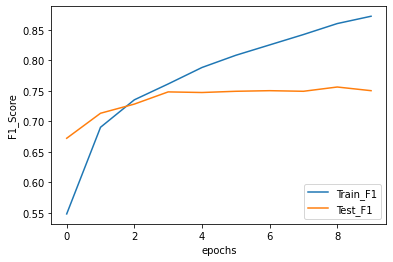

In [416]:
df_overfit.plot()
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("F1_Score")
plt.show()